In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Local -> all other imports in source files
import settings.custom
from prophandler import PropHandler

from __utils import visualize_prop_ratio
from backup_projections import load_backup_projections

SITE = "draftkings"
MODE = "classic" # all changes have been made for "showdown" to replace "single-game"
# MODE = 'showdown'


BACKUP_EDITS_FILE = '../data/backup_projections.json'
# BACKUP_EDITS_FILE = [
#     '../data/historical/2025-05-14.csv',
#     '../data/historical/2025-05-18.csv'
# ]

EDITS = load_backup_projections(file=BACKUP_EDITS_FILE)

In [2]:
handler = PropHandler(
    SITE,
    MODE,
    edits=EDITS,
    # yesterday=True
    # tomorrow=True
)

In [3]:
df = handler.load(
    # Late additions to injury report
    inactive=[],
    update=True,
    sort="fpts/$",
    # sort='fpts'
    # sort='salary',
)

# First run of day (needs to update URL directory): ~6-8 minutes

   ----------------------------------------
   Beginning WebScrape of NBA Player Props.
   ----------------------------------------
Prop projection only: Jonathan Kuminga, PJ Washington, Anthony Davis
Player props added for: Victor Wembanyama, projection went from 56.7 -> 62.12 (+++++).
Player props added for: James Harden, projection went from 48.2 -> 49.88 (+++++).
Player props added for: Stephen Curry, projection went from 44.3 -> 44.88 (+++++).
Player props added for: Jimmy Butler, projection went from 41.4 -> 39.88 (-----).
Player props added for: Stephon Castle, projection went from 40.9 -> 37.88 (-----).
Player props added for: Ivica Zubac, projection went from 40.6 -> 39.12 (-----).
Player props added for: De'Aaron Fox, projection went from 36.7 -> 38.12 (+++++).
Player props added for: Cooper Flagg, projection went from 34.5 -> 35.62 (+++++).
Player props added for: Brandon Williams, projection went from 30.4 -> 30.12 (-----).
Player props added for: Brandin Podziemski, projec

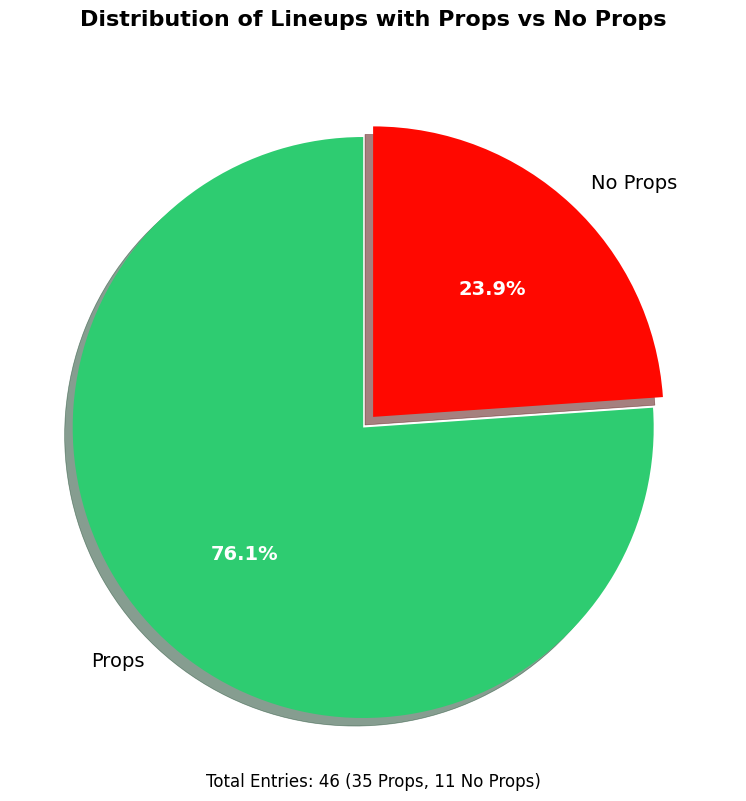

In [4]:
own_df = (pd
          .read_csv(f'/home/deegs/devel/repos/nba-boxscores-git/nba-boxscores/data/2024-2025/contest-files/{SITE}/current/current-ownership.csv')
          .set_index('name')
         )

df['own'] = df.index.map(lambda name: own_df.loc[name, 'own'] if name in own_df.index else 1)

if not df.loc[df['no-props']==1].empty:
    try:
        fig = visualize_prop_ratio(df, cutoff=0.0)
        display(fig)  # Only display once
        plt.close(fig)
    except ValueError:
        print('No props available. Using backup projections for all players.\n')

In [5]:
df

,pos,salary,team,fpts,e_fpts,fpts/$,e_fpts/$,value,no-props,own
name,,,,,,,,,,
Brandon Williams,PG,5400,DAL,30.12,16.07,5.578,2.976,3.12,0,15.0
Ivica Zubac,C,7100,LAC,39.12,21.32,5.510,3.003,3.62,0,21.0
Naji Marshall,SF/PF,5200,DAL,27.88,13.66,5.362,2.627,1.88,0,6.0
Klay Thompson,SG/SF,4200,DAL,22.38,11.63,5.329,2.769,1.38,0,5.0
De'Aaron Fox,PG,7200,SA,38.12,19.92,5.294,2.767,2.12,0,0.0
Victor Wembanyama,C,11800,SA,62.12,32.64,5.264,2.766,3.12,0,0.0
Stephen Curry,PG,8600,GS,44.88,23.49,5.219,2.731,1.88,0,0.0
James Harden,PG,9600,LAC,49.88,25.69,5.196,2.676,1.88,0,6.0
Stephon Castle,SG,7500,SA,37.88,19.70,5.051,2.627,0.38,0,0.0


In [6]:
# set(df.index)

In [7]:
def compare_combos(*combos):
    return {
        combo: df.loc[df.index.isin(combo), 'fpts'].sum()
        for combo in pairs
    }

In [8]:
def top_n_team_distribution(N: int, **kwargs):
    return (df
            [:N]
            .groupby('team')
            [['team']]
            .agg(['count'])
            [('team', 'count')]
            .sort_values(ascending=True)
            .plot
            .barh(
                title=f'Team distribution for top {N} projected players',
                figsize=(9,6)
            )
           )

# top_n_team_distribution(15);

In [9]:
team_dfs = {
    team:
    df.loc[df['team'] == team]
    for team in df['team'].drop_duplicates()
}

In [10]:
import numpy as np
team_dfs[str(np.random.choice(list(team_dfs.keys())))]

,pos,salary,team,fpts,e_fpts,fpts/$,e_fpts/$,value,no-props,own
name,,,,,,,,,,
De'Aaron Fox,PG,7200,SA,38.12,19.92,5.294,2.767,2.12,0,0.0
Victor Wembanyama,C,11800,SA,62.12,32.64,5.264,2.766,3.12,0,0.0
Stephon Castle,SG,7500,SA,37.88,19.70,5.051,2.627,0.38,0,0.0
Devin Vassell,SF,5900,SA,25.38,12.72,4.302,2.156,-4.12,0,0.0
Keldon Johnson,SF/PF,4900,SA,20.88,10.42,4.261,2.127,-3.62,0,0.0
Harrison Barnes,PF,4500,SA,18.62,9.88,4.138,2.196,-3.88,0,0.0
Luke Kornet,C,4300,SA,17.62,9.10,4.098,2.116,-3.88,0,0.0
Julian Champagnie,SG/SF,4600,SA,16.88,8.30,3.670,1.804,-6.12,0,0.0
Jeremy Sochan,PF,4200,SA,6.60,0.00,1.571,0.000,-21.00,1,0.0


#### `handler.constant_scrape()`
##### Repeatedly scrapes props, making sure always as up to date as possible and saving behind the scenes.
##### Caveats include the fact it has an infinite loop built in and that it is pretty useless when it comes to playoffs since books much more on top of lines then.

In [11]:
# handler.constant_scrape(verbose=0)

# 

In [12]:
def get_players_in_range(**kwargs):

    SALARY_RANGE = range(
        kwargs.get('minsal', min(df['salary'])),
        kwargs.get('maxsal', max(df['salary'])),
        100
    )
    
    TEAMS = kwargs.get('team', kwargs.get('teams', list(df['team'].drop_duplicates())))
    if isinstance(TEAMS, str):
        TEAMS = [TEAMS]

    POSITIONS = kwargs.get('pos', list(df['pos'].drop_duplicates()))
    if kwargs.get('pos') in ('G', 'F'):
        POSITIONS = [pos_ for pos_ in df['pos'].drop_duplicates() if kwargs['pos'] in pos_]
    
    return (df
            .loc[
            (df['salary'].isin(SALARY_RANGE)) 
            & (df['team'].isin(TEAMS))
            & (df['pos'].isin(POSITIONS))
            ]
            .sort_values('fpts', ascending=False)
           )

In [13]:
# get_players_in_range(minsal=8_000, maxsal=9_500)